# K-Means Clustering (NumPy Implementation)

This notebook demonstrates K-Means clustering implemented from scratch using NumPy. 

## Scenario: Customer Segmentation

We use a synthetic dataset representing customers of a retail store.  

Features include:

- Annual income  
- Age  
- Spending score (1-100)  
- Visits per month  

Our goal is to group customers into clusters based on similarity, e.g., to identify high-value or budget-conscious groups.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Helper Functions

In [2]:
def generate_customer_data(m = 500, random_state = 42):
    """
    Generate synthetic customer data for clustering.
    """
    np.random.seed(random_state)
    age = np.random.randint(18, 70, m)
    income = np.random.randint(20000, 150000, m)
    spending_score = np.random.randint(1, 101, m)
    visits_per_month = np.random.randint(0, 30, m)

    df = pd.DataFrame({
        "age": age,
        "income": income,
        "spending_score": spending_score,
        "visits_per_month": visits_per_month})

    scaler = StandardScaler()
    X = scaler.fit_transform(df)

    return df, X

## Generate Synthetic Customer Data

In [3]:
df, X = generate_customer_data()
df.head()

,age,income,spending_score,visits_per_month
0,56,23343,81,23
1,69,33500,5,13
2,46,73222,29,23
3,32,49375,4,13
4,60,29662,10,10


The `X` array contains the **scaled features** from the `df` dataframe.  
Scaling is important because K-Means clustering relies on **Euclidean distances** to assign points to clusters.  
If the variables are on different scales, features with larger magnitudes would dominate the distance calculation, leading to biased clusters.  
By using `X` with standardized variables, we ensure that all features contribute equally to the clustering process.

## NumPy Implementation of K-Means

**Step 1: Preprocess & Scale Data**
- Scale the features to ensure no single feature dominates distance calculations.

**Step 2: Initialize Centroids**
- Choose k centroids randomly from the dataset.
- Each centroid represents the "center" of a cluster.

**Step 3: Assign Points to Nearest Centroid**
- Compute distances between each data point and all centroids using Euclidean distance.
- Assign each point to the cluster of the nearest centroid.

**Step 4: Update Centroids**
- For each cluster, compute the mean of all points assigned to it.
- Move the centroid to this new mean location.

**Step 5: Iterate Until Convergence**
- Repeat Step 3 → Step 4 until centroids stop moving significantly (change < tolerance) or until a maximum number of iterations is reached.
- Convergence is reached when cluster assignments no longer change substantially.

**Step 6: Evaluate & Choose Optimal K**
- Use methods like the Elbow Method or Silhouette Score to find the best k.
- Plot total within-cluster distances (inertia) vs. k to see the "elbow" point.

**Step 7: Visualize Clusters**

### Helper functions for K-Means

In [4]:
def kmeans(X, k, max_iters = 100):
    """
    NumPy implementation of K-Means clustering.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Input data.
    k : int
        Number of clusters.
    max_iters : int, optional
        Maximum number of iterations (default 100).

    Returns
    -------
    labels : np.ndarray, shape (n_samples,)
        Cluster assignment for each data point.
    centroids : np.ndarray, shape (k, n_features)
        Final centroid positions.
    """
    # Randomly initialize centroids by picking k unique points from X
    indices = np.random.choice(X.shape[0], k, replace = False)
    centroids = X[indices]

    # Iterate the clustering process
    for i in range(max_iters):
        dist = []

        # Compute Euclidean distance from each centroid to all points
        for center in centroids:
            dist.append(np.sqrt(((X - center) ** 2).sum(axis = 1)))

        # Convert list of distance arrays into a 2D array: shape (n_samples, k)
        all_numbers = np.array([[arr[i] for arr in dist] for i in range(len(dist[0]))])

        # Assign each point to the closest centroid
        labels = np.argmin(all_numbers, axis = 1)

        # Update centroid positions as the mean of points assigned to each cluster
        new_centroids = np.array([X[labels == i].mean(axis = 0) for i in range(k)])

        # Check for convergence: stop if centroids move less than tolerance
        if np.all(np.abs(new_centroids - centroids) < 1e-4):
            break

        # Prepare for next iteration
        centroids = new_centroids

    # Return final cluster assignments and centroids
    return labels, centroids

## Run K-Means

In [5]:
labels, centroids = kmeans(X, 3)
print("Cluster centroids:\n", centroids)

Cluster centroids:
 [[-1.0454584  -0.28374024  0.12710862 -0.40136528]
 [ 0.25130031  0.93808777 -0.17708385  0.33109829]
 [ 0.74376727 -0.88975891  0.0934527  -0.00888401]]


## Visualize Clusters

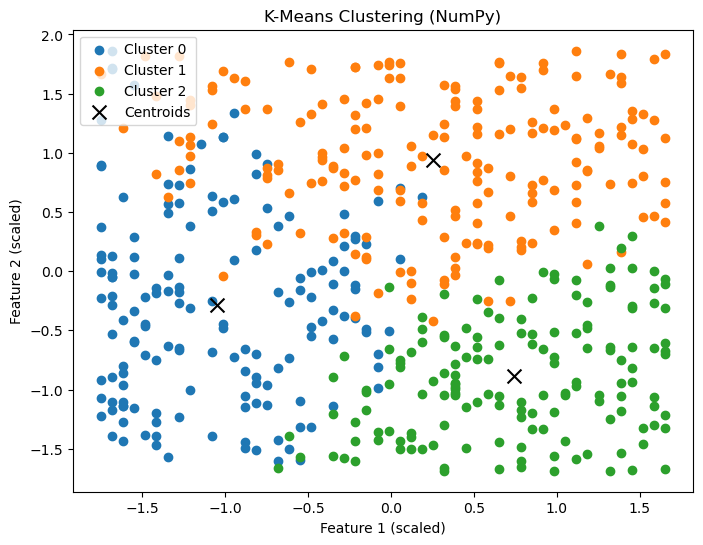

In [6]:
plt.figure(figsize = (8,6))
for i in range(3):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label = f"Cluster {i}")
plt.scatter(centroids[:, 0], centroids[:, 1], color = 'black', marker = 'x', s = 100, label = 'Centroids')
plt.title("K-Means Clustering (NumPy)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()

The visualization shows three distinct clusters of data points in the 2D feature space. Points that belong to the same cluster are grouped together and share the same color, while the centroids of each cluster are marked with black “×” symbols. The distances between the centroids represent how similar or dissimilar the clusters are relative to one another.

It is important to note, however, that this plot only shows the first two features of the dataset. The full dataset actually contains four variables, so the visualization provides a **partial view** of the clustering results. While it is helpful for understanding the general structure and separation of clusters, it does not capture the complete relationships across all four dimensions. Additional techniques, such as pair plots or dimensionality reduction methods like PCA, could be used to better visualize clustering in higher-dimensional space.

## Elbow Method for Optimal K

Within K-Means clustering, the Within-Cluster Sum of Squares (WSS) measures the total squared distance between each point and its cluster centroid, reflecting how compact the clusters are. In the Elbow Method, WSS is calculated for different numbers of clusters. 

The “elbow” point in the plot, where adding more clusters yields diminishing reductions in WSS, helps to identify the optimal number of clusters that balances compactness and simplicity.

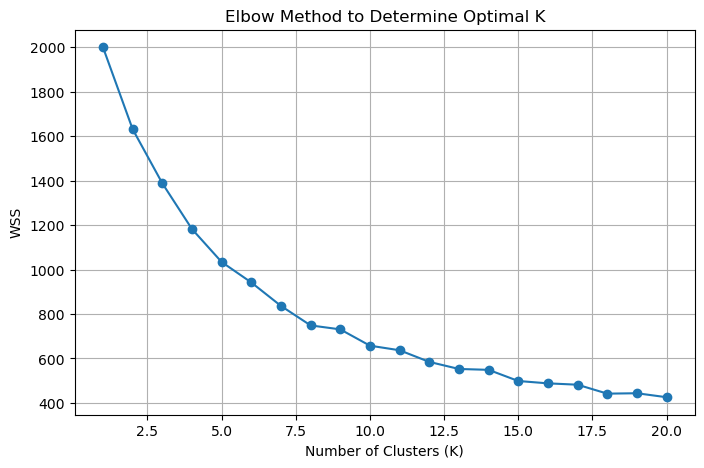

In [7]:
def compute_wss(X, labels, centroids):
    wss = 0
    for i in range(centroids.shape[0]):
        wss += ((X[labels == i] - centroids[i]) ** 2).sum()
    return wss

wss_values = []
k_range = range(1, 21)
for k in k_range:
    labels, centroids = kmeans(X, k)
    wss_values.append(compute_wss(X, labels, centroids))

plt.figure(figsize = (8,5))
plt.plot(k_range, wss_values, marker = 'o')
plt.title("Elbow Method to Determine Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WSS")
plt.grid(True)
plt.show()

From the plot generated, the “elbow” occurs at **8 clusters**, indicating that increasing the number of clusters beyond 8 results in only marginal reductions in WSS and that 8 is a suitable choice for the optimal number of clusters.

## Summary

This notebook demonstrates how K-Means clustering can group similar data points without labels.

- Initialization: Random selection of centroids

- Iteration: Assign points → update centroids

- Convergence: Stop when centroids no longer change

For datasets with high dimensionality, which is common in real-world applications, Principal Component Analysis (PCA) can be applied to reduce the number of features while preserving most of the variance, making clustering more efficient and easier to visualize. Additionally, the silhouette score provides a more robust measure of clustering quality compared to WSS, as it evaluates both the cohesion within clusters and the separation between clusters, rather than just the compactness of clusters alone.